# Book Data Linkage Statistics

This notebook presents linkage statistics for the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bookdata.db import db_url

## Load Link Stats

The `integration_stats` table in the database contains link success statistics in our data.

In [3]:
link_stats = pd.read_sql_table('integration_stats', db_url())
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,no-loc-author,843706,NaN
1,LOC-MDS,female,664157,NaN
2,LOC-MDS,unknown,1214561,NaN
3,LOC-MDS,ambiguous,53019,NaN
4,LOC-MDS,male,2194657,NaN


Let's create lists for our different codes, in order, for later handling.  We'll start with the resolved codes:

In [4]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [5]:
unlink_codes = ['no-viaf-author', 'no-loc-author', 'no-book']

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot(index='dataset', columns='gender', values='n_books')
book_counts = book_counts.reindex(columns=link_codes + unlink_codes)
book_counts

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,213902.0,476724.0,16854.0,234088.0,154921.0,144989.0,1027394.0
BX-E,38087.0,55939.0,3991.0,16903.0,7661.0,6465.0,22735.0
BX-I,67071.0,96994.0,6739.0,34632.0,15673.0,12916.0,45669.0
GR-E,172953.0,272728.0,10903.0,94553.0,34198.0,495701.0,NaN
GR-I,174572.0,276093.0,11005.0,96316.0,35014.0,503902.0,NaN
LOC-MDS,664157.0,2194657.0,53019.0,1214561.0,296903.0,843706.0,NaN


In [7]:
act_counts = link_stats.pivot(index='dataset', columns='gender', values='n_actions')
act_counts = act_counts.reindex(columns=link_codes + unlink_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,4281101.0,6512944.0,522983.0,2045342.0,782399.0,2085552.0,6231611.0
BX-E,138667.0,184591.0,30736.0,27458.0,9807.0,9417.0,26464.0
BX-I,391304.0,466535.0,76979.0,77959.0,26352.0,25781.0,64510.0
GR-E,32374238.0,33491507.0,8168343.0,3593338.0,604877.0,8314444.0,NaN
GR-I,70853353.0,68114258.0,13225960.0,9564873.0,1719727.0,25473714.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1: continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,0.094277,0.210115,0.007428,0.103174,0.068281,0.063904,0.452821
BX-E,0.250934,0.368551,0.026294,0.111364,0.050474,0.042594,0.149788
BX-I,0.239801,0.346786,0.024094,0.123821,0.056036,0.046179,0.163282
GR-E,0.159988,0.252284,0.010086,0.087465,0.031634,0.458543,NaN
GR-I,0.159150,0.251703,0.010033,0.087807,0.031921,0.459387,NaN
LOC-MDS,0.126098,0.416680,0.010066,0.230598,0.056370,0.160187,NaN


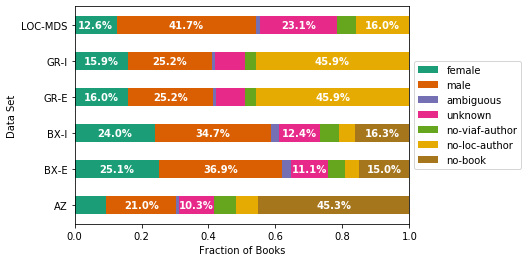

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.094277,0.210115,0.007428,0.103174,0.585006
BX-E,0.250934,0.368551,0.026294,0.111364,0.242856
BX-I,0.239801,0.346786,0.024094,0.123821,0.265497
GR-E,0.159988,0.252284,0.010086,0.087465,0.490177
GR-I,0.159150,0.251703,0.010033,0.087807,0.491307
LOC-MDS,0.126098,0.416680,0.010066,0.230598,0.216557


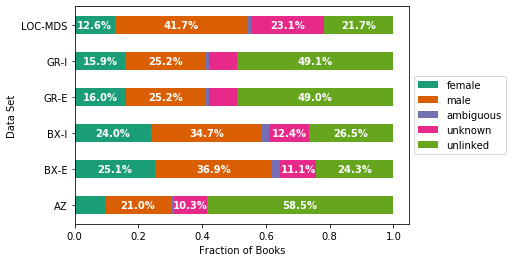

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

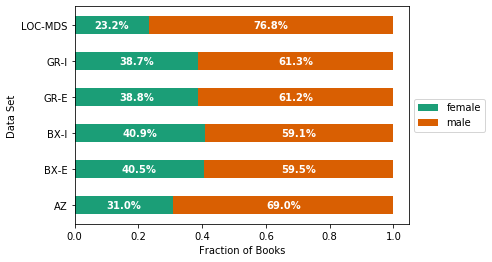

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,0.190594,0.289955,0.023283,0.091058,0.034832,0.092848,0.277430
BX-E,0.324641,0.432156,0.071958,0.064283,0.022960,0.022047,0.061956
BX-I,0.346465,0.413075,0.068158,0.069026,0.023332,0.022827,0.057118
GR-E,0.374066,0.386976,0.094381,0.041519,0.006989,0.096069,NaN
GR-I,0.374981,0.360485,0.069996,0.050621,0.009101,0.134816,NaN


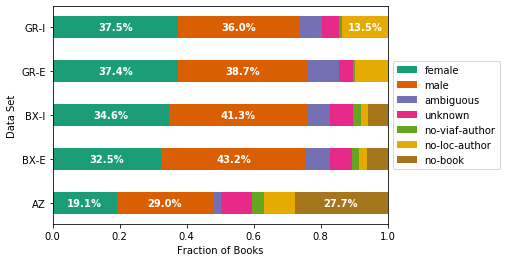

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.190594,0.289955,0.023283,0.091058,0.405110
BX-E,0.324641,0.432156,0.071958,0.064283,0.106963
BX-I,0.346465,0.413075,0.068158,0.069026,0.103277
GR-E,0.374066,0.386976,0.094381,0.041519,0.103058
GR-I,0.374981,0.360485,0.069996,0.050621,0.143917


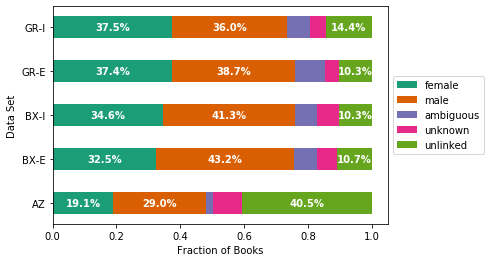

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

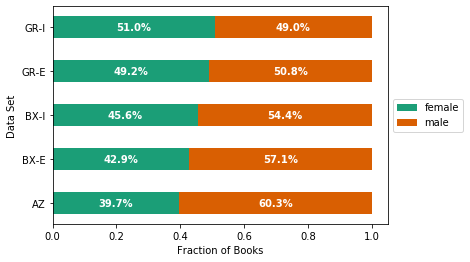

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))